Exercise-based on a dataset published on Kaggle: https://www.kaggle.com/mirichoi0218/insurance

**Goal:** Finding a model which can  accurately predict insurance costs.

**Propouse:**
- Accomplishing an exploratory data analysis on the dataset.
- Identifying and dealing with possible skewed data, where applicable.
- Accomplishing hypothesis tests by analyzing data variation, where applicable.
- Accomplishing normality tests.
- Identifying possible correlations.
- Solving possible overfitting and underfitting problems, if necessary.
- Accomplishing data normalization and coeficient regularization techniques, if necessary.
- Finding which algorithm have the best performance: Linear Regression, DecisionTreeRegressor, Lasso, GradientBoostingRegressor, Ridge, KNeighborsRegressor, PLSRegression, ElasticNet, XGBRegressor, XGBRFRegressor and RandomForestRegressor
- Applying K-Fold cross-validation.
- Validating results with confusion matrix
- Checking algorithms' results variability.

**Solution author's Linkedin profile:** https://bit.ly/3tsOnU3

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import zipfile
import os
import math
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectFdr, f_regression
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler, BorderlineSMOTE, SMOTENC, SMOTEN
from imblearn.under_sampling import AllKNN, TomekLinks, EditedNearestNeighbours, CondensedNearestNeighbour
from imblearn.under_sampling import InstanceHardnessThreshold, RepeatedEditedNearestNeighbours, OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from xgboost import XGBRegressor, XGBRFRegressor
from scipy.stats import norm, shapiro
import warnings

warnings.filterwarnings("ignore")
abs_path = os.getcwd()

# 1. Get dataset by Kaggle API

In [2]:
parquet_file = "insurance.parquet"
csv_file = "insurance.csv"
zip_file = "insurance.zip"

if os.path.isfile(parquet_file):
    print ("There is a parquet file!!!")
    dataset = pd.read_parquet(parquet_file)
else:
    """
    Get the compressed dataset (.zip file), 
    Extract .csv file,
    Deletr .zip file,
    Load .csv jupyter to jupyter notebook,
    Delete .csv file,
    Generate .parquet file
    """
    print ("There is no file")
    !kaggle datasets download -d mirichoi0218/insurance
    with zipfile.ZipFile(zip_file,"r") as zip_ref:
        zip_ref.extractall(abs_path)
    os.remove(zip_file)
    dataset = pd.read_csv(csv_file)
    dataset.to_parquet(parquet_file, engine='pyarrow')
    os.remove(csv_file)
    
dataset.head()

There is a parquet file!!!


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Exploratory Data Analysis

In [3]:
dataset.shape

(1338, 7)

**Analysis:** By getting "non-null" results below, it proves:
- There is no null data, so there is no need to delete elements/columns or to add data by interpolation.

**Analysis:** Between explicative variables, there are some qualitative variables ("object" type), quantiative ones - discrete (most of them of "int64" type) and continuous (most of them of "float64"). 

**Analysis:** Afterwards, it was noticed it is necessary to apply data normalization technique to some columns.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
np.unique(dataset['region'], return_counts=True)

(array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object),
 array([324, 325, 364, 325], dtype=int64))

**Analysis:** There is some skewed data, it can be seen on "charge" column histogram and on its boxplot.

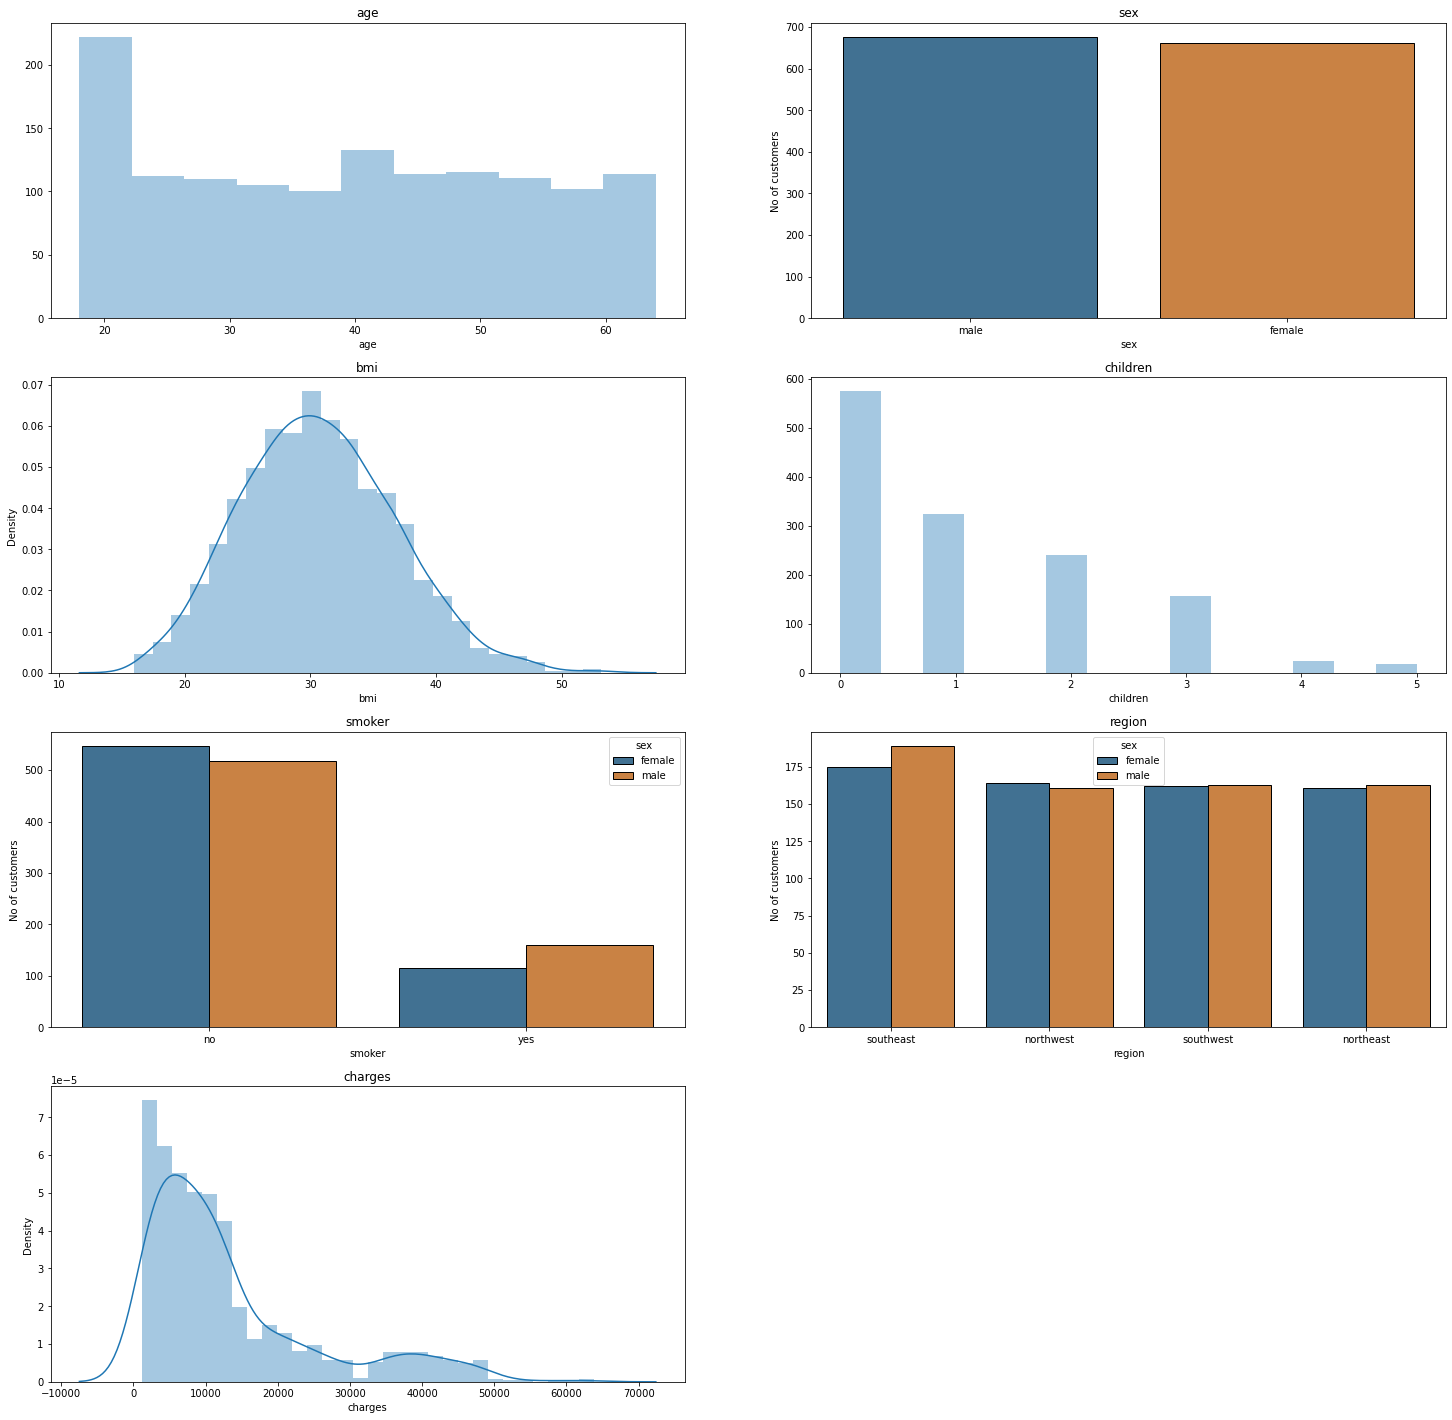

In [7]:
subplot_columns_amount = 2
first_index = 0
subplot_rows_amount = math.ceil(len(dataset.iloc[:,first_index:].columns)/subplot_columns_amount)

_, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(25,25))

for count, column in enumerate(dataset.iloc[:,first_index:].columns):
    current_ax = ax[count//subplot_columns_amount][count%subplot_columns_amount]
    current_ax.set_title(column)
    if dataset[column].dtype in ["int64", "float64"]:
        kde = True if dataset[column].dtype == "float64" else False
        sns.distplot(dataset[column], kde=kde, ax=current_ax)
    else:
        data = pd.DataFrame(dataset[column].groupby(dataset[column]).size().reset_index(name='Amount'))
        current_ax.set_ylabel("No of customers")
        # Descending ordering based on element amount for each class of each column
        # Afterwards, reshaping operation is needed after .value, because it returns a matrix
        order = dataset[column].groupby(dataset[column]).size().reset_index(name='grouping').sort_values(by=['grouping'], ascending=False).iloc[:,:1].values
        hue = dataset['sex'] if column != "sex" else None
        sns.countplot(x = dataset[column], edgecolor = 'black', saturation = 0.55, 
                          ax=current_ax, hue=hue, order=order.reshape((order.shape[0])))
        current_ax.set_ylabel('No of customers')
        
# Delete empty frames
qtd_frames_vazios = subplot_columns_amount*subplot_rows_amount - len(dataset.iloc[:,first_index:].columns)
[ax.flat[-i].set_visible(False) for i in range(1, qtd_frames_vazios+1)]
plt.show()
plt.close()

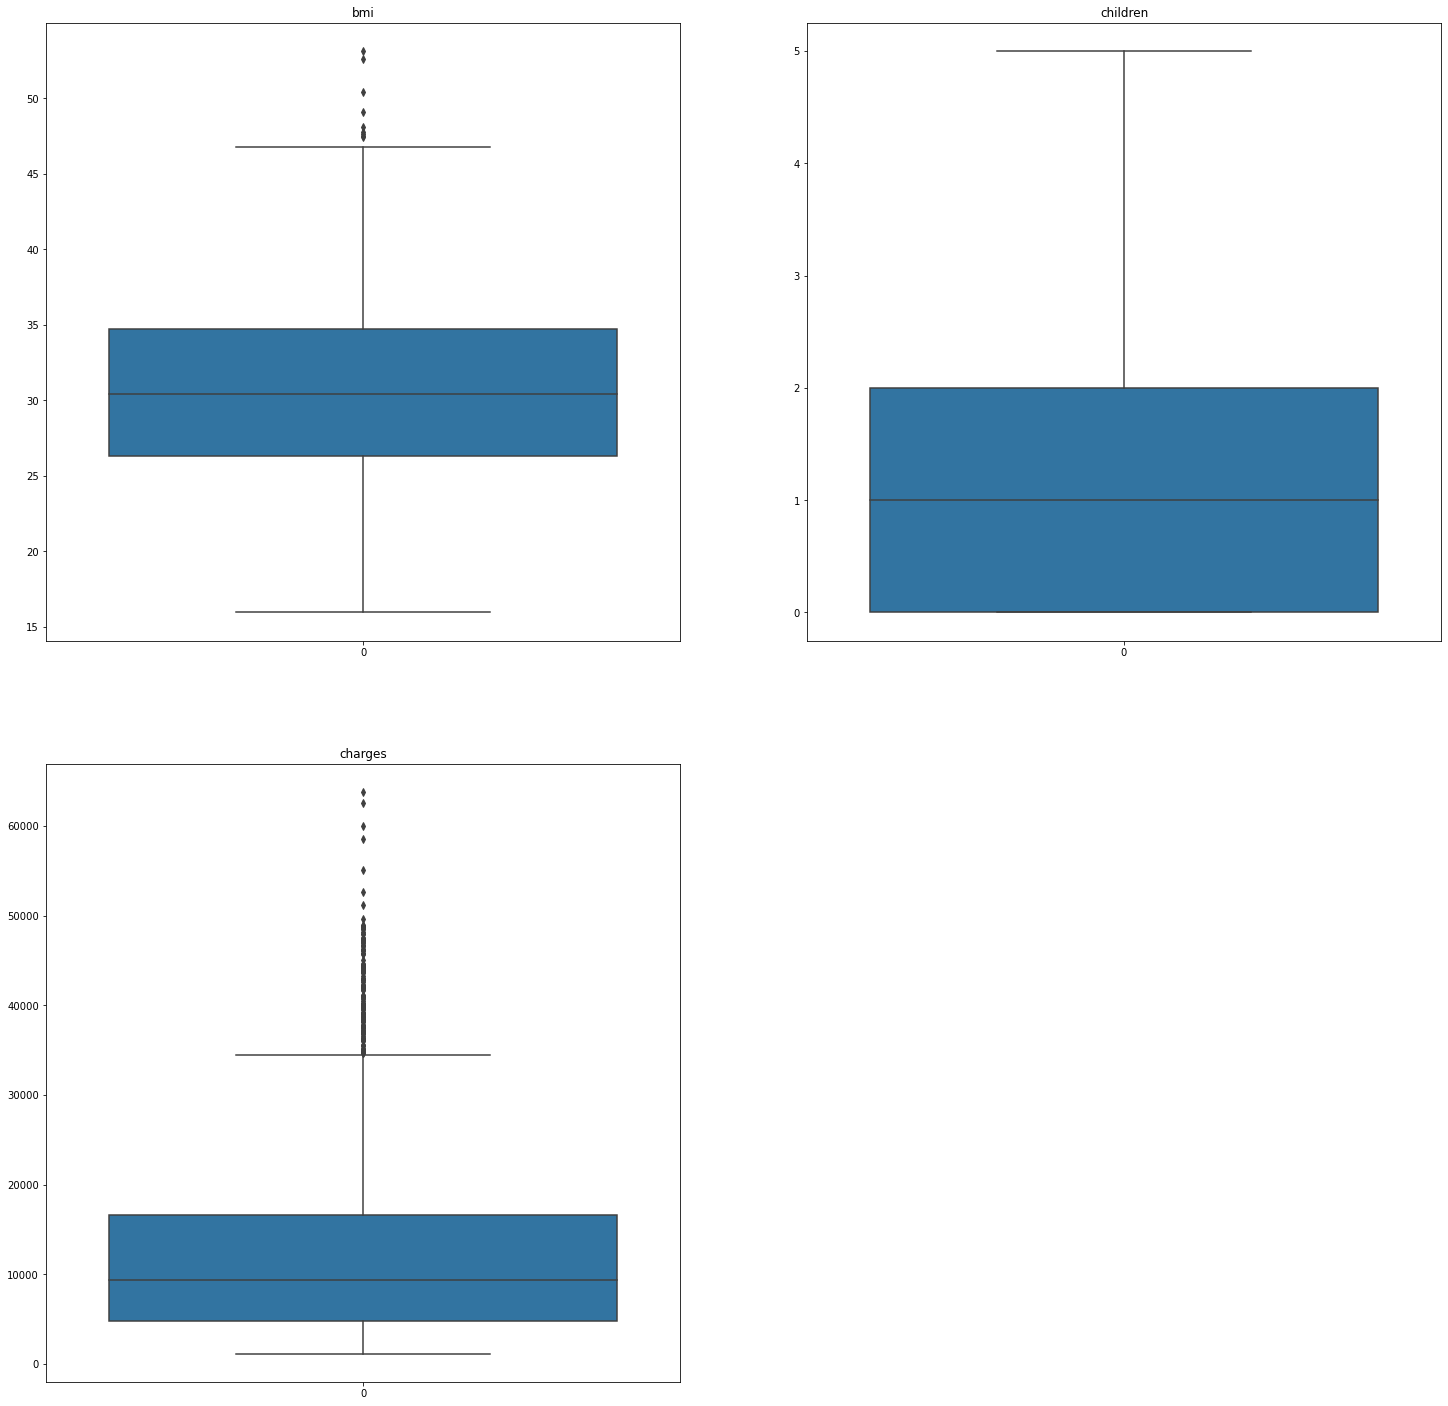

In [8]:
numeric_columns = (dataset.iloc[:,1:].dtypes != "object").reset_index(name='Amount').query('Amount == True')['index'].values

subplot_columns_amount = 2
subplot_rows_amount = math.ceil(len(numeric_columns)/subplot_columns_amount)
_, ax = plt.subplots(subplot_rows_amount, subplot_columns_amount, figsize=(25,25))

for count, column in enumerate(numeric_columns):
    current_ax = ax[count//subplot_columns_amount][count%subplot_columns_amount]
    current_ax.set_title(column)
    plt.subplot(sns.boxplot(data=dataset[column], ax=current_ax))

# Delete empty frames
amount_empty_frames = subplot_columns_amount*subplot_rows_amount - len(numeric_columns)
[ax.flat[-i].set_visible(False) for i in range(1, amount_empty_frames+1)]
plt.show()
plt.close()

In [9]:
# Encode data

dataset_encoded = dataset.iloc[:,:].copy()

for column in dataset_encoded.columns:
    if dataset_encoded[column].dtype == "object":
        label_encoder = LabelEncoder()
        dataset_encoded[column] = label_encoder.fit_transform(dataset_encoded[column])
dataset_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


**Analysis:** The heatmap for Pearson correlation table below proves no explicative variable is, at least, on moderate level, according to Evans classification, Evans (1996, also http://leg.ufpr.br/~silvia/CE003/node74.html, on Brazilian portuguese)

<function matplotlib.pyplot.close(fig=None)>

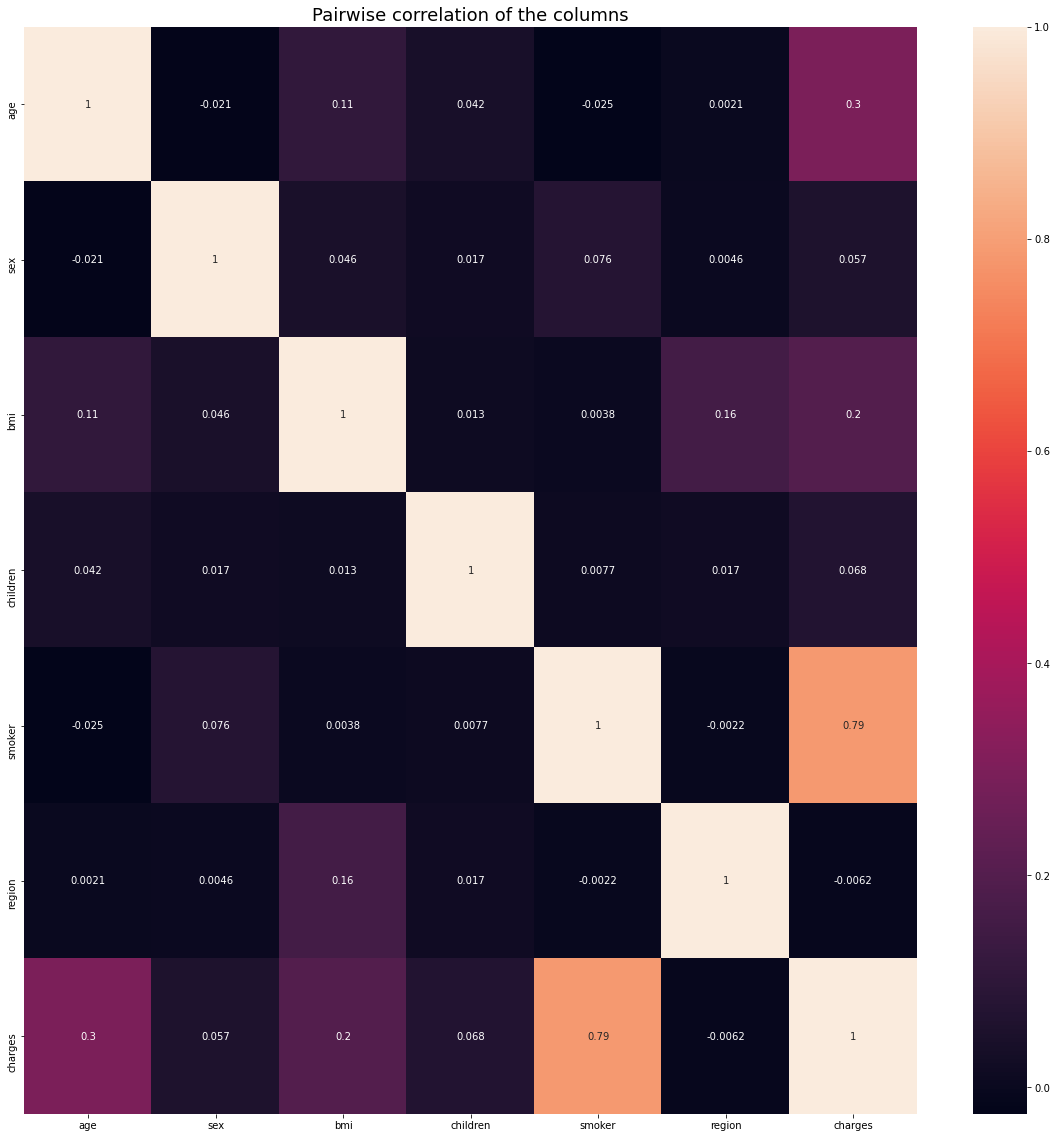

In [10]:
fig, ax = plt.subplots(figsize = (20, 20))
plt.title("Pairwise correlation of the columns", fontsize = 18)
ax = sns.heatmap(dataset_encoded.corr(), annot = True)
plt.close

**Analysis:** Pairwise relationships graphics below proves it's going to be hard to the algorithms learning how to distinguish elements from both classes. Probably, undersampling techniques can solve this problem. Also, oversampling can solve the unbalanced data problem.

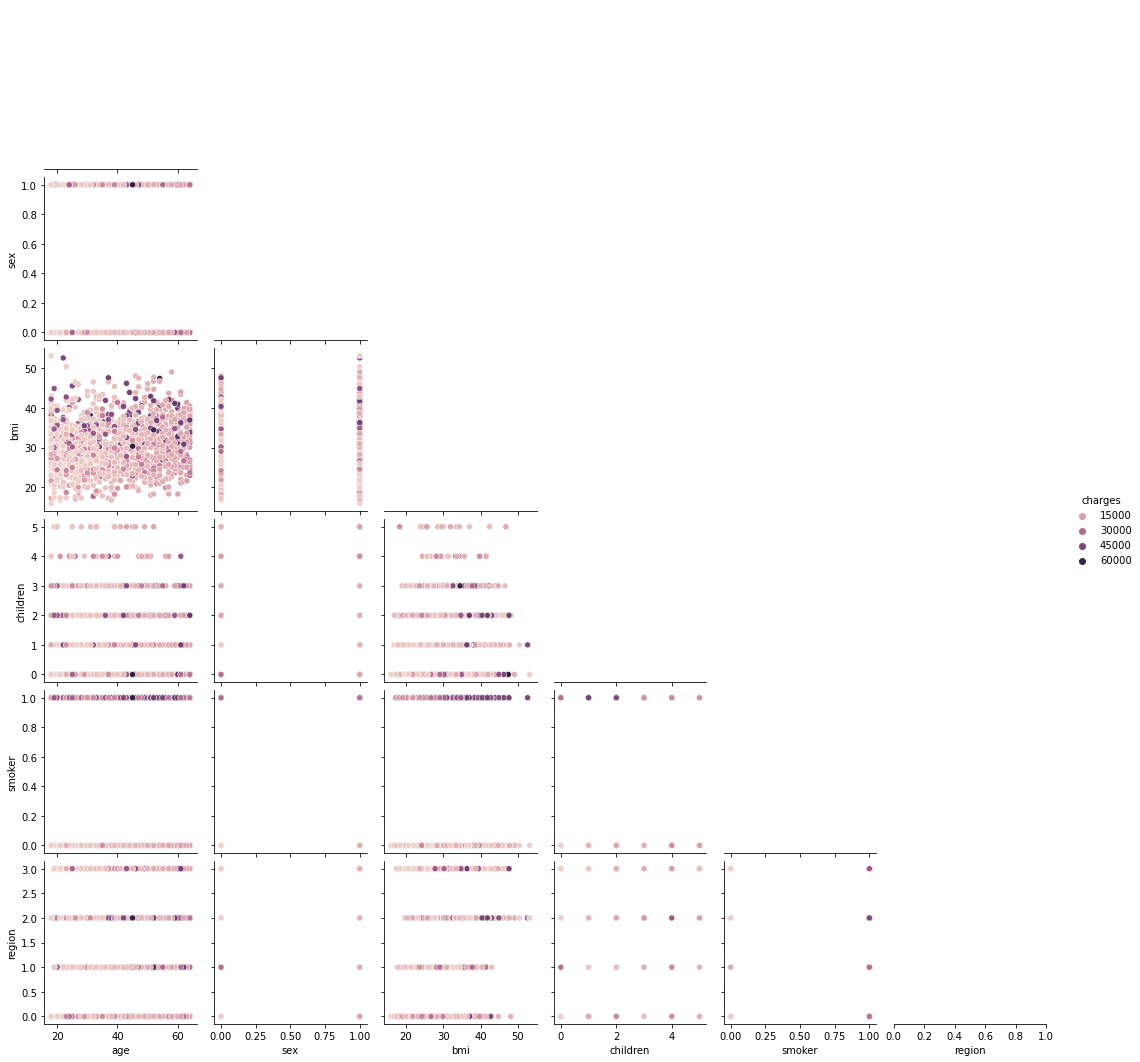

In [11]:
sns.pairplot(dataset_encoded, hue = "charges", corner=True)
plt.show()

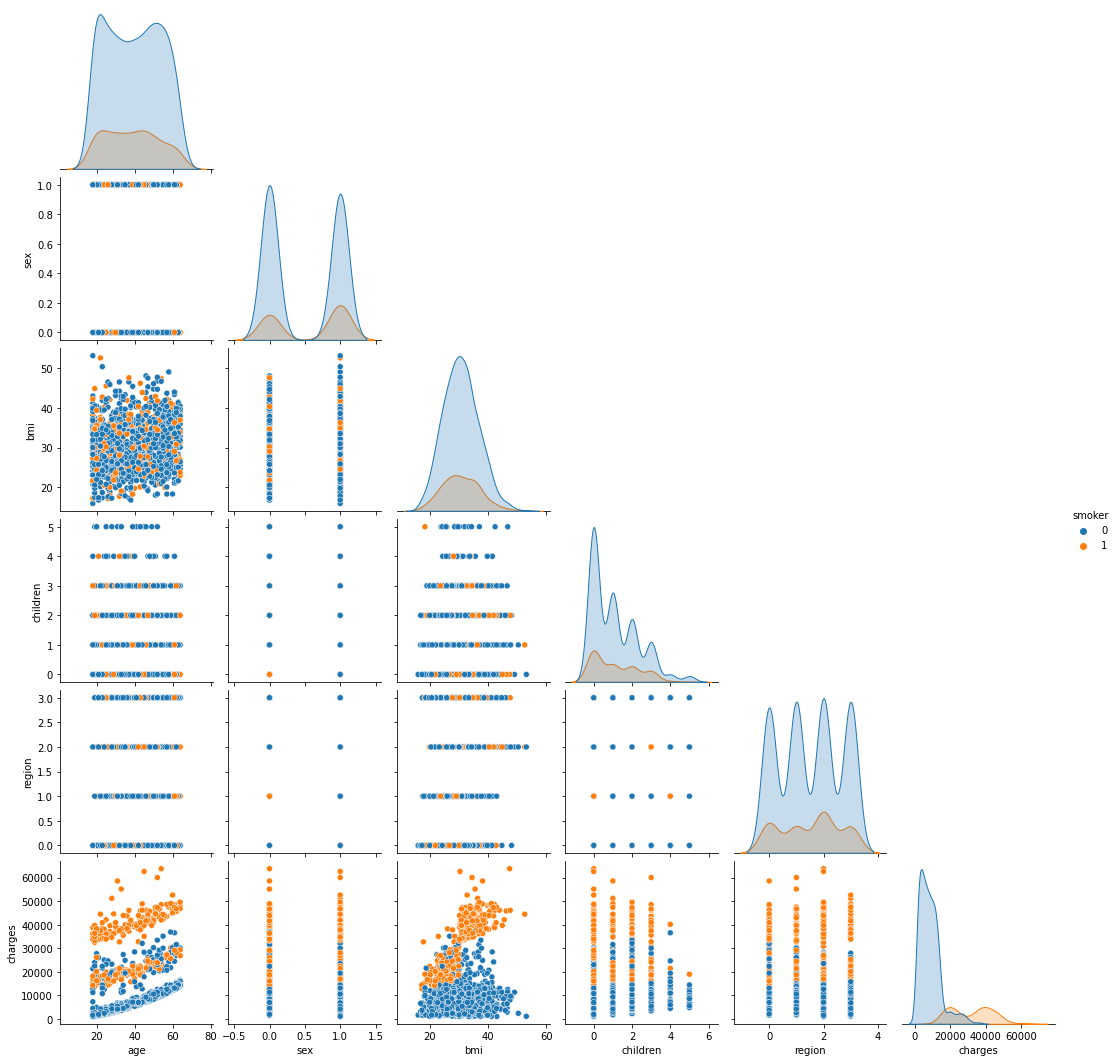

In [12]:
sns.pairplot(dataset_encoded, hue = "smoker", corner=True)
plt.show()

# 3. Model training and testing 

## 3.1. No treatment applied on models - With skewed data and no attribute selection

**Explicative variables**

In [13]:
x = dataset_encoded.iloc[:,:-1].values
y = dataset_encoded.iloc[:,-1:].values.reshape(dataset_encoded.shape[0])
dataset_encoded.iloc[:,:-1].head()

,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,3
1,18,1,33.770,1,0,2
2,28,1,33.000,3,0,2
3,33,1,22.705,0,0,1
4,32,1,28.880,0,0,1


**Response variable**

In [14]:
dataset_encoded.iloc[:,-1:].head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


In [15]:
def plot_algorithms_r2_scores_comparison(results_dict):
    plt.figure(figsize = (12,6)) 
    mean_score_list = []
    [mean_score_list.append(np.mean(results_dict[key]["r2"])) for key in results_dict]
    ax = sns.barplot(list(results_dict.keys()), mean_score_list)
    ax.set_xticklabels(list(results_dict.keys()), fontsize = 18, rotation = 90)
    plt.title("Comparison of the models - By R2 score", fontsize = 18)
    plt.ylabel("Forecast accuracy")
    plt.show()
    plt.close()
    
def plot_r2_confidence_interval(results_dict):
    for key in results_dict:
        print("Confidence interval - R2 Score - {:<20}: {}".format(key, 
                                                                   norm.interval(0.95,
                                                                                 np.mean(results_dict[key]["r2"]),
                                                                                 stats.sem(results_dict[key]["r2"]))))

def get_model(model_name, variables_dict, random_state):
    if model_name == "LinearRegression":
        variables_dict[model_name]["model"] = LinearRegression()
    elif model_name == "Lasso":
        variables_dict[model_name]["model"] = Lasso()
    elif model_name == "RandomForestRegressor":
        variables_dict[model_name]["model"] = RandomForestRegressor()
    elif model_name == "GradientBoostingRegressor":
        variables_dict[model_name]["model"] = GradientBoostingRegressor(max_depth=3)
    elif model_name == "Ridge":
        variables_dict[model_name]["model"] = Ridge()
    elif model_name == "KNeighborsRegressor":
        variables_dict[model_name]["model"] = KNeighborsRegressor(n_neighbors=5)
    elif model_name == "DecisionTreeRegressor":
        variables_dict[model_name]["model"] = DecisionTreeRegressor()
    elif model_name == "PLSRegression":
        variables_dict[model_name]["model"] = PLSRegression()
    elif model_name == "ElasticNet":
        variables_dict[model_name]["model"] = ElasticNet()
    elif model_name == "XGBRegressor":
        variables_dict[model_name]["model"] = XGBRegressor(max_depth = 2, learning_rate = .2)
    elif model_name == "XGBRFRegressor":
        variables_dict[model_name]["model"] = XGBRFRegressor()
        
def plot_statistics(results):
    '''
    print("Score mean:")
    for key in results:
        print("\t{:<25}: {:.5f} %".format(key, np.mean(results[key]["score"])))
    '''
    print("MAE mean:")
    for key in results:
        print("\t{:<25}: {:.5f}".format(key, abs(np.mean(results[key]["mae"]))))

    print("MSE mean:")
    for key in results:
        print("\t{:<25}: {:.5f}".format(key, abs(np.mean(results[key]["mse"]))))

    print("R2 score mean:")
    for key in results:
        print("\t{:<25}: {:.5f}".format(key, abs(np.mean(results[key]["r2"]))))

def plot_r2_scores_distplot(results_dict):
    plt.figure(figsize=(20,20))
    colors = ["red", "blue", "green", "orange", "brown", "gray", "black", "yellow", "cyan", "crimson", "peru"]

    for index,key in enumerate(results_dict):
        plt.subplot(3, len(list(results_dict.keys()))/2, index+1)
        plt.title(key)
        plt.subplot(sns.distplot(results_dict[key]["score"], 
                                 color=colors[index], label=key, hist=True, kde=False, axlabel="Accuracy"))
        plt.legend();        

def plot_results(results):
    plot_statistics(results)
    plot_r2_confidence_interval(results)
    plot_r2_scores_distplot(results)
    plot_algorithms_r2_scores_comparison(results)
        
def train(x, y, train_loop, norm = None):
    variables = {
        "LinearRegression":          { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "Lasso":                     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "RandomForestRegressor":     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "GradientBoostingRegressor": { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "Ridge":                     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "KNeighborsRegressor":       { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "DecisionTreeRegressor":     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "PLSRegression":             { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "ElasticNet":                { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "XGBRegressor":              { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "XGBRFRegressor":            { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] }
    }
    
    for i in range(train_loop):
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = i)
        # data normalization during training
        if norm:
            st = StandardScaler()
            st.fit(x_train)
            x_train = st.transform(x_train)
            x_test = st.transform(x_test)
        
        for key in variables:        
            get_model(key, variables, random_state = i)
            variables[key]["model"].fit(x_train, y_train)
            variables[key]["prediction"] = variables[key]["model"].predict(x_test)
            variables[key]["score"].append(variables[key]["model"].score(x_test, y_test))
            variables[key]["mae"].append(mean_absolute_error(y_test, variables[key]["prediction"]))
            variables[key]["mse"].append(mean_squared_error(y_test, variables[key]["prediction"]))
            variables[key]["r2"].append(r2_score(y_test, variables[key]["prediction"]))
    return variables

def train_kfold(x, y, train_loop):
    variables = {
        "LinearRegression":          { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "Lasso":                     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "RandomForestRegressor":     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "GradientBoostingRegressor": { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "Ridge":                     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "KNeighborsRegressor":       { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "DecisionTreeRegressor":     { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "PLSRegression":             { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "ElasticNet":                { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "XGBRegressor":              { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] },
        "XGBRFRegressor":            { "score": [], "prediction": 0, "model": None, "mae": [], "mse": [], "r2": [] }
    }
    
    for i in range(train_loop):
        kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
        
        for key in variables:            
            get_model(key, variables, random_state = i)
            scores = cross_val_score(variables[key]["model"], x, y, cv = kfold)
            variables[key]["score"].append(scores.mean())
            scores_mae = cross_val_score(variables[key]["model"], x, y, scoring='neg_mean_absolute_error', cv = kfold)
            variables[key]["mae"].append(scores_mae.mean())
            scores_mse = cross_val_score(variables[key]["model"], x, y, scoring='neg_mean_squared_error', cv = kfold)
            variables[key]["mse"].append(scores_mse.mean())
            scores_r2 = cross_val_score(variables[key]["model"], x, y, scoring='r2', cv = kfold)
            variables[key]["r2"].append(scores_r2.mean())
    return variables

MAE mean:
	LinearRegression         : 4210.02010
	Lasso                    : 4209.89113
	RandomForestRegressor    : 2654.63495
	GradientBoostingRegressor: 2491.05965
	Ridge                    : 4211.25243
	KNeighborsRegressor      : 3170.78680
	DecisionTreeRegressor    : 2998.78143
	PLSRegression            : 4200.12133
	ElasticNet               : 5122.08177
	XGBRegressor             : 2480.14237
	XGBRFRegressor           : 2496.30104
MSE mean:
	LinearRegression         : 36783193.77841
	Lasso                    : 36782540.76346
	RandomForestRegressor    : 23123763.00387
	GradientBoostingRegressor: 20443675.33514
	Ridge                    : 36780598.66764
	KNeighborsRegressor      : 27753669.32024
	DecisionTreeRegressor    : 40935250.32141
	PLSRegression            : 36778926.65794
	ElasticNet               : 48536026.54399
	XGBRegressor             : 20243518.91227
	XGBRFRegressor           : 20216270.91612
R2 score mean:
	LinearRegression         : 0.74769
	Lasso                    :

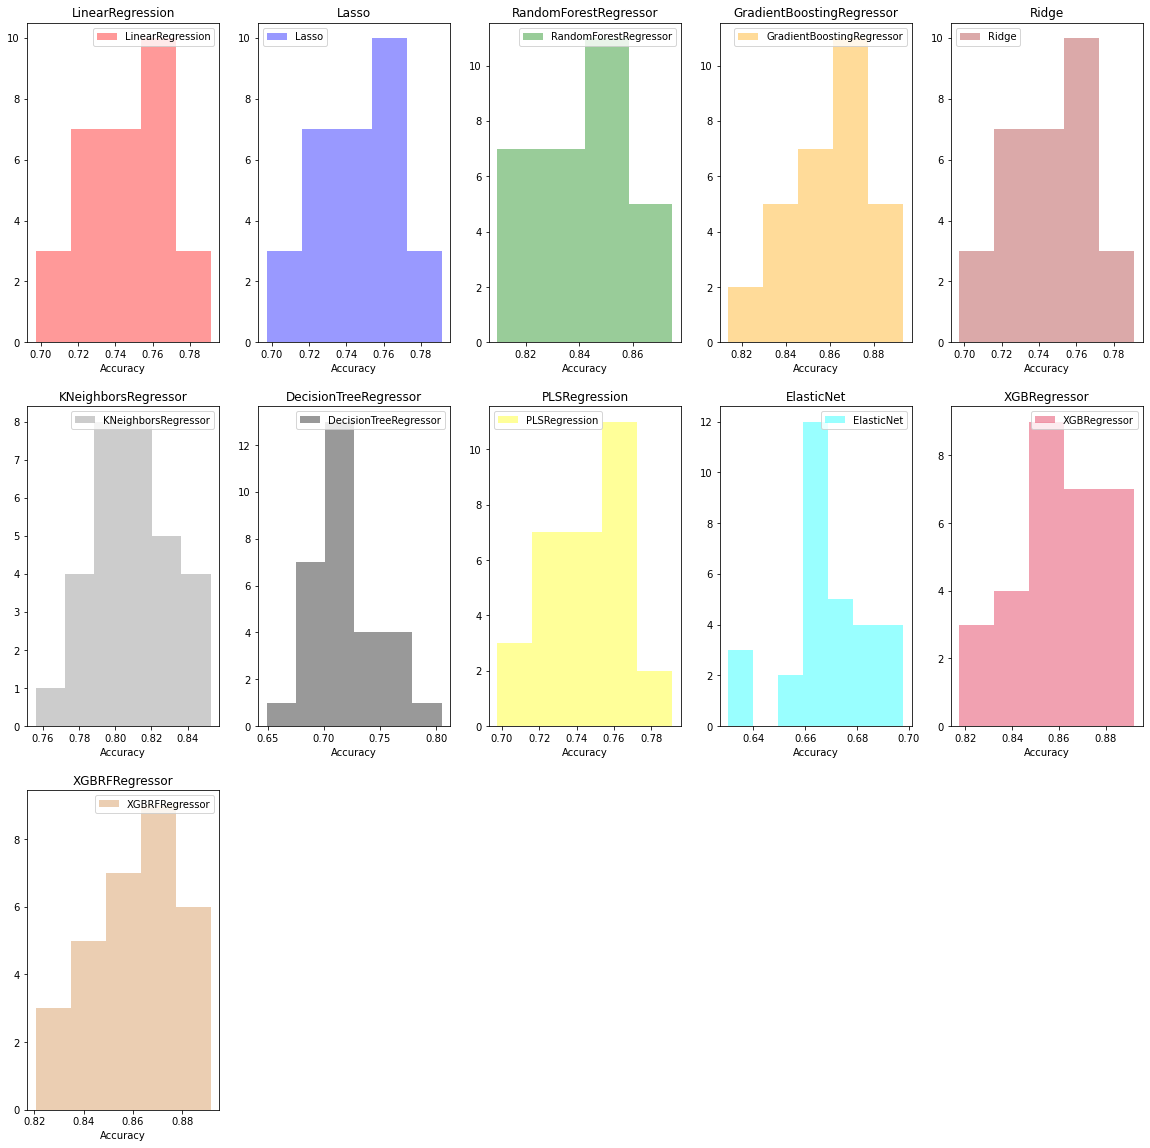

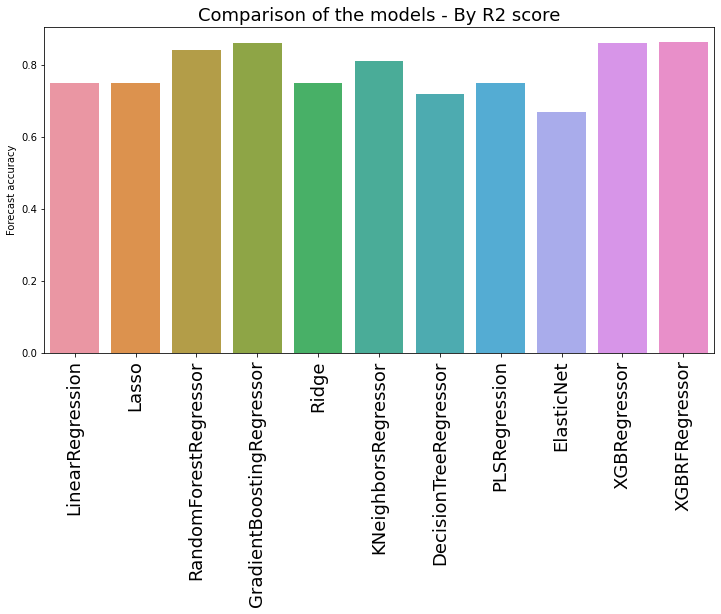

In [16]:
def train_models(x, y):
    train_loop = 30
    return train(x, y, train_loop, True)
    
results = train_models(x, y)
plot_results(results)

## 3.2. Oversampling and Undersampling Technique - With skewed data, no attribute selection, normalized data with Standard Scaler, dataset size for test 30%

**Analysis:** on exploratory data analysis, it was seen that the main explicative variable ("smoker", 79% according to the "Pairwise correlation of the columns" heatmap table) is unbalanced between its two classes: one class has 3.8832 more times elements than the other one. So, Oversampling and Undersampling technique were choosen to solve this problem and a satisfactory result was achieved.
The Oversampling (RandomOverSampler) and Undersampling (RepeatedEditedNearestNeighbours) techniques choosen in this project are the same used in the "Credit Card" classfication project which is in this same Github repository, and on that ocasion they showed a satisfactory performance improvement for the algorithms.

Smoker variable's classes distribution before applying Oversampling and Undersampling techniques: (array([0, 1]), array([1064,  274], dtype=int64))
Smoker variable's classes distribution after applying Oversampling and Undersampling techniques:(array([0, 1]), array([958, 958], dtype=int64))
MAE mean:
	LinearRegression         : 5073.17607
	Lasso                    : 5073.13893
	RandomForestRegressor    : 474.46152
	GradientBoostingRegressor: 912.73013
	Ridge                    : 5073.61422
	KNeighborsRegressor      : 1534.38986
	DecisionTreeRegressor    : 390.46572
	PLSRegression            : 5064.52499
	ElasticNet               : 6350.91430
	XGBRegressor             : 1023.80163
	XGBRFRegressor           : 1016.92435
MSE mean:
	LinearRegression         : 35934332.19138
	Lasso                    : 35933760.56953
	RandomForestRegressor    : 1971837.58415
	GradientBoostingRegressor: 4188936.97839
	Ridge                    : 35934640.46236
	KNeighborsRegressor      : 9091301.32134
	Decisi

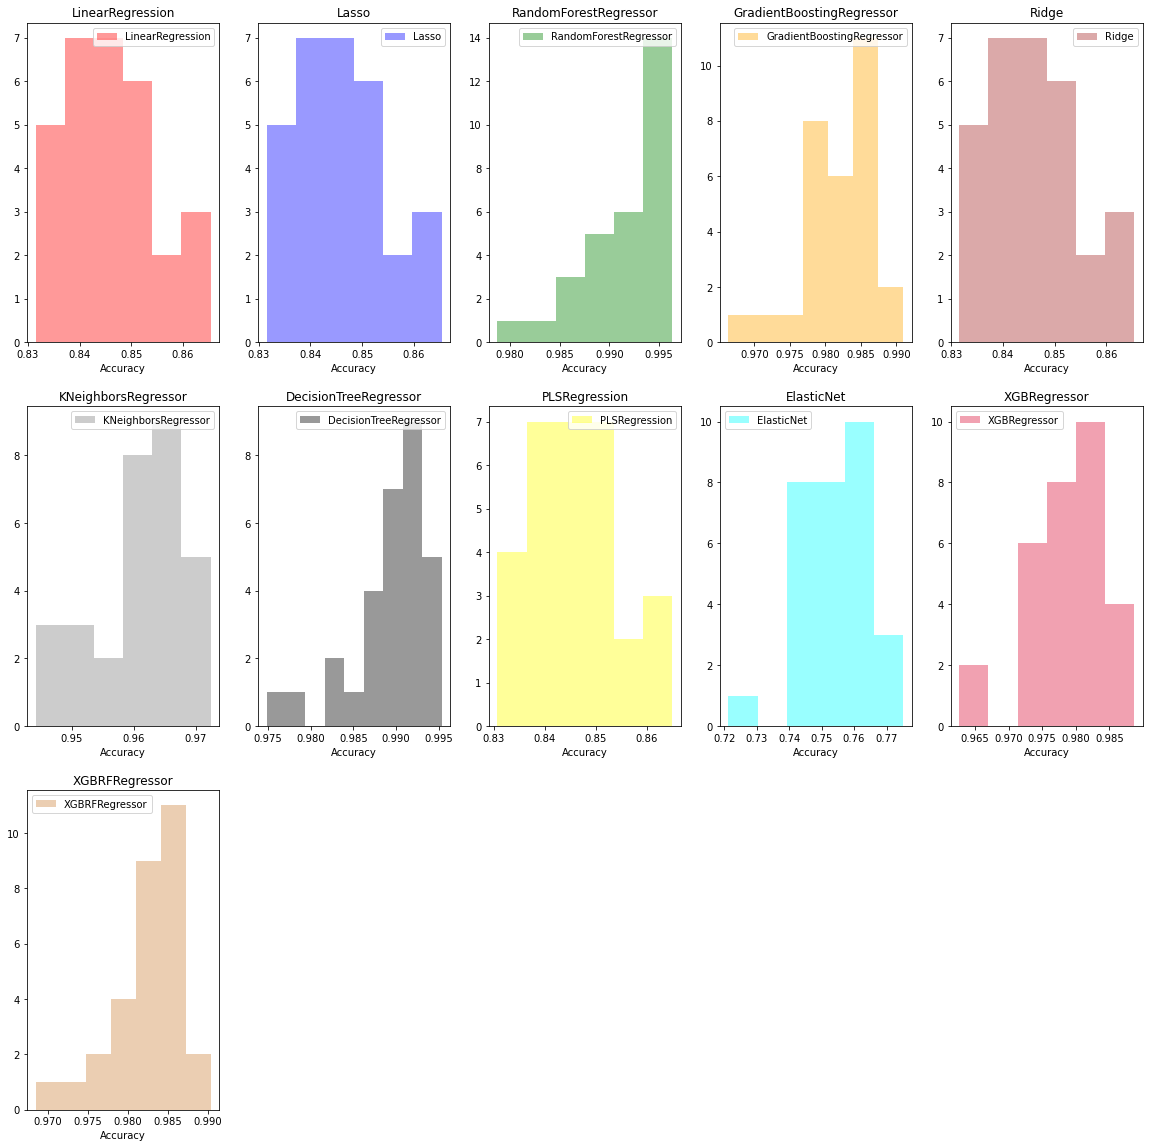

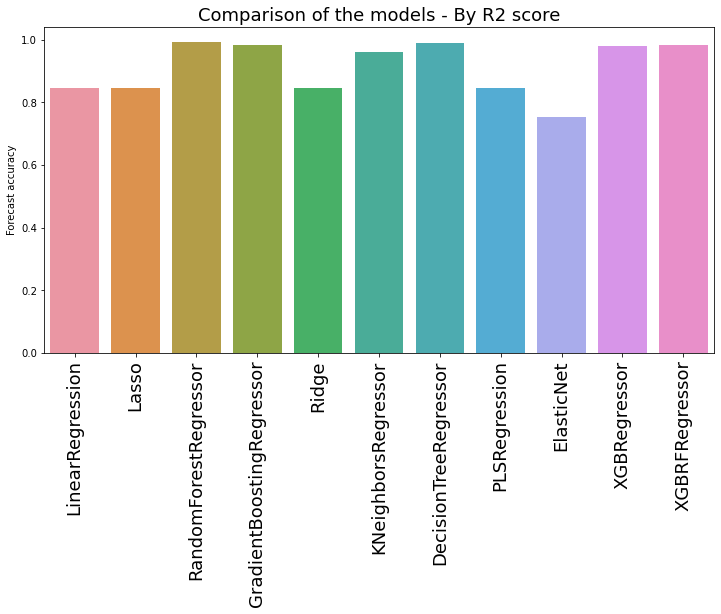

In [17]:
def prepare_data(dataset_encoded):
    temp_x = dataset_encoded[['age', 'sex', 'bmi', 'children', 'region', 'charges']]
    temp_y = dataset_encoded[['smoker']]
    print("Smoker variable's classes distribution before applying Oversampling and Undersampling techniques: " + str(np.unique(dataset_encoded['smoker'], return_counts=True)))
    
    rnn = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
    temp_x, temp_y = rnn.fit_resample(temp_x, temp_y)
    
    ros = RandomOverSampler(sampling_strategy='minority')
    temp_x, temp_y = ros.fit_resample(temp_x, temp_y)

    print("Smoker variable's classes distribution after applying Oversampling and Undersampling techniques:" + str(np.unique(temp_y['smoker'], return_counts=True)))
    dataset_encoded = pd.concat([temp_x, temp_y], axis = 1)
    
    x = dataset_encoded[['age', 'sex', 'bmi', 'children', 'region', 'smoker']].values
    y = dataset_encoded[['charges']].values.reshape(dataset_encoded.shape[0])
    return [x, y]

def train_models(dataset_encoded):
    x, y = prepare_data(dataset_encoded)
    train_loop = 30
    
    return train(x, y, train_loop, True)
    
results = train_models(dataset_encoded)
plot_results(results)

## 3.3. K-Fold cross-validation and a combination of Oversampling and Undersampling techniques - With skewed data, no attribute selection, dataset size for test 30%

Smoker variable's classes distribution before applying Oversampling and Undersampling techniques: (array([0, 1]), array([1064,  274], dtype=int64))
Smoker variable's classes distribution after applying Oversampling and Undersampling techniques:(array([0, 1]), array([958, 958], dtype=int64))
MAE mean:
	LinearRegression         : 5153.53965
	Lasso                    : 5153.57434
	RandomForestRegressor    : 364.51406
	GradientBoostingRegressor: 954.70134
	Ridge                    : 5154.97247
	KNeighborsRegressor      : 6740.55590
	DecisionTreeRegressor    : 287.51179
	PLSRegression            : 5150.67973
	ElasticNet               : 8499.87496
	XGBRegressor             : 1069.02453
	XGBRFRegressor           : 1073.00070
MSE mean:
	LinearRegression         : 37515056.87134
	Lasso                    : 37514635.01212
	RandomForestRegressor    : 1233782.55231
	GradientBoostingRegressor: 4273022.09724
	Ridge                    : 37515612.64704
	KNeighborsRegressor      : 108578722.01740
	Deci

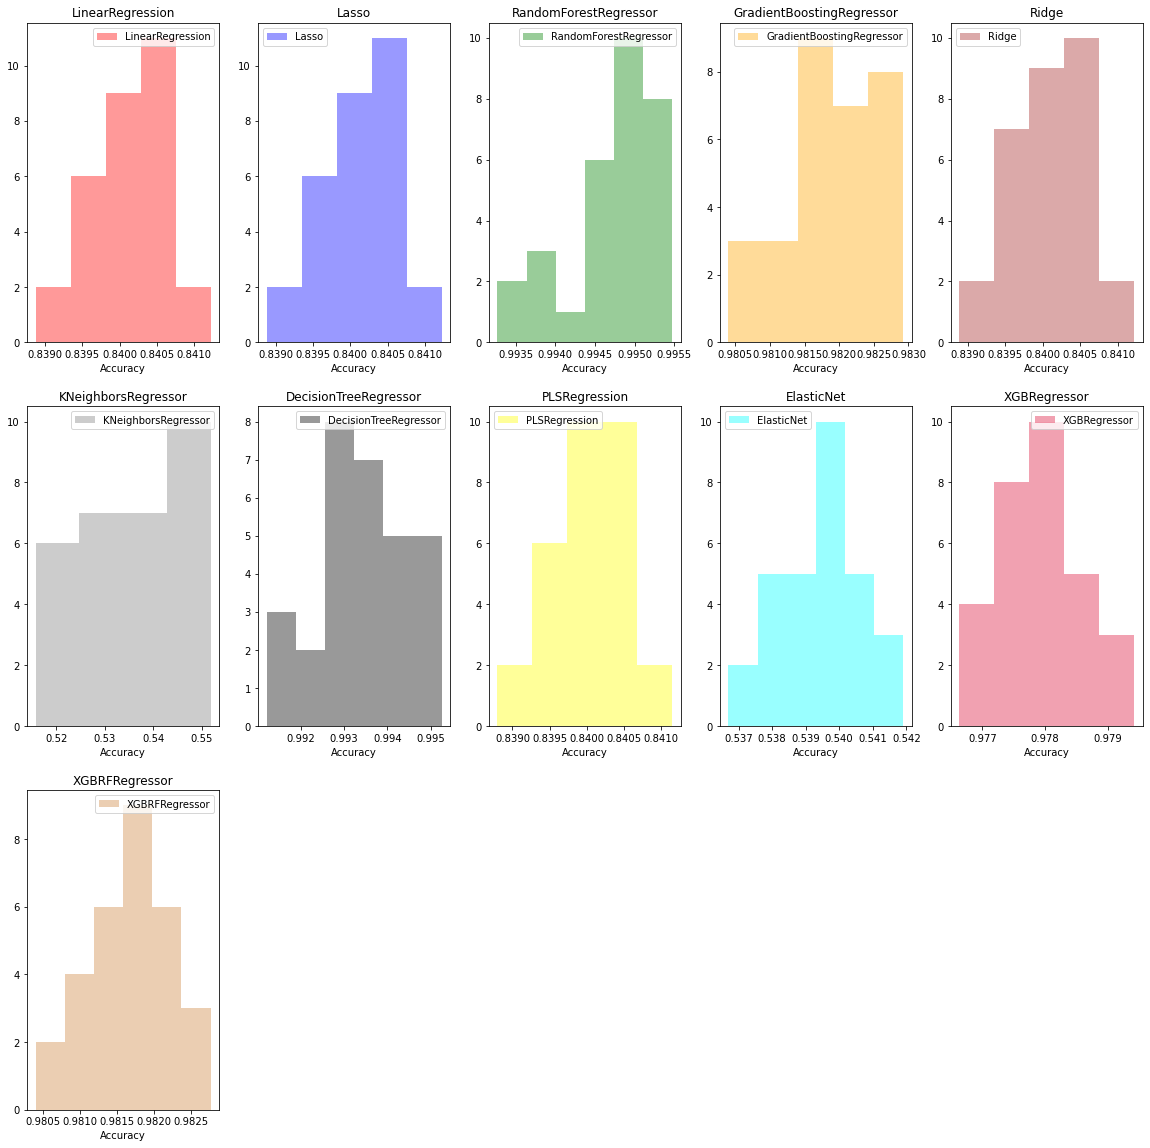

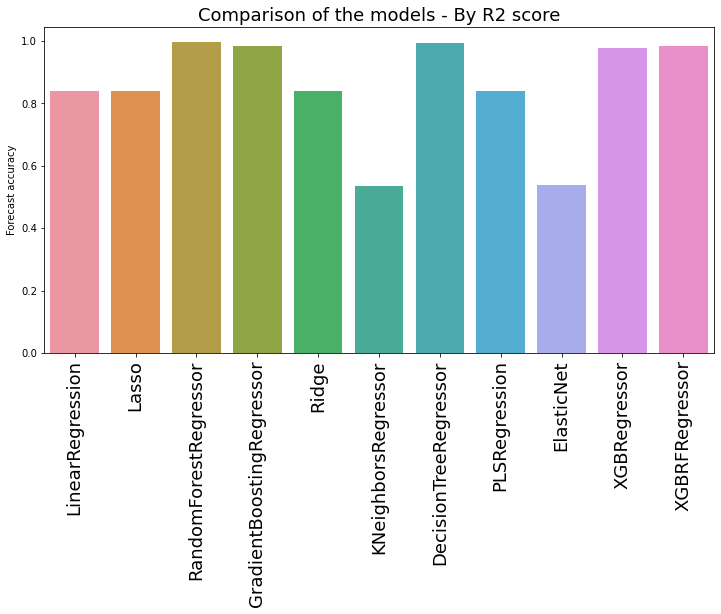

In [18]:
def train_models(dataset_encoded):
    x, y = prepare_data(dataset_encoded)
    train_loop = 30
    
    return train_kfold(x, y, train_loop)
    
results = train_models(dataset_encoded)
plot_results(results)

In [19]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

# 4. Conclusion

Even with no data transformation for skewed data, a good result was achieved with both algorithms during tests after applying oversampling and undersampling techniques, under 30 training loops. Such techniques improved algorithms performance by average of 12.56% (standard deviation - 5,396) over the same algorithms with no oversampling and undersampling techniques. The DecisionTreeRegressor was improved in 27.17%.
After K-Fold cross-validation, section 3.3, KNeighborsRegressor algorithms had its performance decreased in 45.5% and ElasticNet in 21.976%. Other algorithms had their performance reduced less than 1% during K-Fold cross-validation.
The best algorithms R2 Score during K-Fold cross-validation were: RandomForestRegressor(99.434%), DecisionTreeRegressor(99.317%), XGBRFRegressor(98.128%), GradientBoostingRegressor(97.992%, and XGBRegressor(97.645%).

In [21]:
!jupyter nbconvert --to html --output "notebook_file" "insurance.ipynb" --no-input

[NbConvertApp] Converting notebook insurance.ipynb to html
[NbConvertApp] Writing 1574788 bytes to notebook_file.html
